In [3]:
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score,recall_score,accuracy_score
import torch.nn.functional as F

 Data processing

In [4]:
# ROOT =os.path.realpath("/kaggle/input/recommender")

# class Ml_latest_small():
    # __BASE = os.path.join(ROOT,'ml-latest-small')
    # SEQS = os.path.join(__BASE, 'seqs.npy')

In [5]:
def getTrainAndTestSeqs(inPath, test_ratio=0.1):
    seqs = np.load(inPath)

    allItems = set()
    for seq in seqs:
        allItems|=set(seq[:-1])

    np.random.shuffle(seqs)
    split_number = int(len(seqs)*test_ratio)
    test = seqs[:split_number]
    train = seqs[split_number:]
    return train, test, allItems

In [6]:
train, test, allItems = getTrainAndTestSeqs('data_set\ml-latest-small\seqs.npy')#Ml_latest_small.SEQS)
n_items = len(allItems) + 2 
print(train[:5])

[[4244 8208 3974 2723 2730 1831    1]
 [5120  718 2421 3984 2491 7939    0]
 [7155 2187 4969 8515  532 1371    1]
 [3288 1359 8288 2421 6405 1699    1]
 [5492 8515 1403 1796  930 5865    1]]


In [7]:
def read_data(data):
    # 获取所有物品ID并分配索引
    item2idx = {item: idx for idx, item in enumerate(allItems)}
    inputs = []
    outputs = []
    for row in data:
        input_seq = np.array([item2idx[item] for item in row[:5]], dtype=np.int64)
        output_seq = np.array([item2idx[row[5]]], dtype=np.int64)
        output_label = np.array([row[6]], dtype=np.float32)
        inputs.append(input_seq)
        outputs.append((output_seq, output_label))
    return inputs,outputs

In [8]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        x = torch.zeros(5, dtype=torch.long)
        y = torch.tensor(np.array(self.targets[idx]),  dtype=torch.float32)
        for i in range(5):
            x[i] = self.data[idx][i]
        return x, y

In [9]:
train_inputs,train_outputs=read_data(train)
test_inputs,test_outputs=read_data(test)

# 返回 PyTorch Dataset 对象和物品数量
train_dataset = MyDataset(train_inputs, train_outputs)
test_dataset = MyDataset(test_inputs, test_outputs)
print(train_dataset[0])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

(tensor([3349, 6459, 3132, 2139, 2144]), tensor([[1.4500e+03],
        [1.0000e+00]]))


model construction

In [10]:
class OutputsHiddenJointModel(nn.Module):
    def __init__(self, n_items, item_dim, hidden_dim, dropout_p):
        super(OutputsHiddenJointModel, self).__init__()
        self.item_dim = item_dim
        self.hidden_dim = hidden_dim
        self.item_embeddings = nn.Embedding(n_items, item_dim)
        self.rnn = nn.RNN(item_dim, hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, input_seq, cur_item):
        
        # 获取输入序列的物品向量表示
        input_emb = self.dropout(self.item_embeddings(input_seq)) #[64, 5, 128]
        # 将物品向量表示输入到RNN中得到所有时间步的输出和隐藏状态
        rnn_out, hn_out = self.rnn(input_emb)
        # 获取当前正在浏览的物品的向量表示
        cur_item_emb = self.item_embeddings(cur_item.long()) #[64, 1, 128]
        # 计算评分，通过非线性激活函数对结果进行处理
        hn=hn_out.permute(1, 0, 2) #[64, 1, 128] 
        score = nn.functional.relu(torch.sum(hn * cur_item_emb, dim=1))
        score = self.linear(score)
        rnn_out = self.linear(rnn_out)
        return score, rnn_out


In [11]:
# 定义损失函数
def loss_function(predicted_scores, real_scores, outputs, target_seq):
    mse_loss = nn.MSELoss()(predicted_scores, real_scores)
    ce_loss=F.cross_entropy(outputs[:, -1, :],target_seq)
    return mse_loss*0.5 + ce_loss*0.5

In [12]:
model = OutputsHiddenJointModel(n_items, 128, 128, dropout_p=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.001)


drill and test

In [13]:
num_epochs = 10
batch_size = 64

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    num_batches = 0
    for batch_inputs, batch_outputs in train_loader:
        optimizer.zero_grad()
        cur_item = batch_outputs[:, 0]
        score, output = model(batch_inputs, cur_item)
        predicted_scores = score
        target_scores = batch_outputs[:, 1]
        loss = loss_function(predicted_scores, target_scores, output, cur_item )
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
    train_loss /= num_batches
    
   
    model.eval() # 将模型切换到评估模式
    test_loss = 0.0
    test_acc = 0.0
    num_batches = 0
    with torch.no_grad(): # 关闭梯度计算
        for batch_inputs, batch_outputs in test_loader:
            cur_item = batch_outputs[:, 0]
            score, output = model(batch_inputs, cur_item)
            predicted_scores = score
            target_scores = batch_outputs[:, 1]
            loss = loss_function(predicted_scores, target_scores, output, cur_item )
            test_loss += loss.item()
            num_batches += 1
    test_loss /= num_batches
    
    print('Epoch [{}/{}], Train Loss: {:.4f}，Test Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, test_loss))

Epoch [1/10], Train Loss: 0.1240，Test Loss: 0.1165
Epoch [2/10], Train Loss: 0.1071，Test Loss: 0.1174
Epoch [3/10], Train Loss: 0.0931，Test Loss: 0.1203
Epoch [4/10], Train Loss: 0.0754，Test Loss: 0.1303
Epoch [5/10], Train Loss: 0.0577，Test Loss: 0.1370
Epoch [6/10], Train Loss: 0.0432，Test Loss: 0.1475
Epoch [7/10], Train Loss: 0.0325，Test Loss: 0.1532
Epoch [8/10], Train Loss: 0.0245，Test Loss: 0.1608
Epoch [9/10], Train Loss: 0.0188，Test Loss: 0.1685
Epoch [10/10], Train Loss: 0.0146，Test Loss: 0.1699


In [14]:
def doEva(y_true, y_pred):
    #评估模型
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    acc = accuracy_score(y_true,y_pred)
    return p,r,acc

Recall is 0.6901947148817803, Precision is 0.6793292265571527, Accuracy is 0.5881027489860298


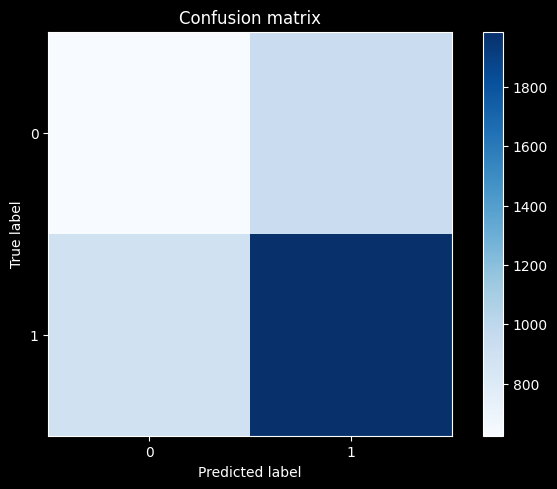

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    totalrec = 0
    totalpre = 0
    totalacc = 0 # 初始化
    all_target_scores = []
    all_predicted_scores = []
    for batch_inputs, batch_outputs in test_loader:
        target_scores = batch_outputs[:, 1]
        score, output = model(batch_inputs, cur_item)
        #将hn的值转为0或1
        score[score >= 0.5] = 1.
        score[score < 0.5] = 0.
        
        p, r, acc = doEva(target_scores, score)
        totalrec+=r
        totalpre+=p
        totalacc+=acc
        
        all_target_scores.extend(target_scores.tolist())
        all_predicted_scores.extend(score.tolist())

# 打印评估指标
n = len(test_loader)
print(f"Recall is {totalrec / n}, Precision is {totalpre / n}, Accuracy is {totalacc / n}")

# 打印混淆矩阵
cm = confusion_matrix(all_target_scores, all_predicted_scores)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(2) # 二元分类问题
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()